In [165]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from os import path
import urllib.request
from shapely.geometry import Point

In [18]:
import google_streetview.api as gsv
import os

Outline: 
* data sourcing
    * set up google api to download images
    * generate random lat, long
    * test location for being in urban area covered by map
    * use street view to find nearest image
    * get image metadata inc lat lon & direction
    * see if there is sidewalk centerline w/in 10ft?, create label in dataframe
* modeling
    * create tf model to classify images, train/test/validate
* use pretrained model to do object detection of sidewalks
* cluster sidewalks by type
    

In [1]:
pwd

'C:\\Users\\User\\Documents\\GitHub\\sidewalks_deep-learning'

In [175]:
#download data sources if not there
data_urls = {}
data_urls['sidewalk_extent'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_extent_centerline_sidewalks&outputFormat=application%2Fjson'
data_urls['sidewalk_centerlines'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_centerline_sidewalks&outputFormat=application%2Fjson'
data_urls['road_borders'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_eop_line&outputFormat=application%2Fjson'

for key, value in data_urls.items():
    if not path.exists(key + ".geojson"):
        urllib.request.urlretrieve(value, key + '.geojson')

In [208]:
sidewalk_gdf = gpd.read_file('sidewalk_centerlines.geojson')
sidewalk_extent_gdf = gpd.read_file('sidewalk_extent.geojson')

In [128]:
sidewalk_gdf.head()

,id,gid,createdate,createuser,type,comments,update_sta,unique_id,geometry
0,planimetrics_2016_centerline_sidewalks.534414,534414,2016-04-08,Kucera,Sidewalk,None,N,534414,"MULTILINESTRING ((3096575.759 1779104.505, 309..."
1,planimetrics_2016_centerline_sidewalks.534415,534415,2016-04-08,Kucera,Sidewalk,None,N,534415,"MULTILINESTRING ((3095429.059 1779035.067, 309..."
2,planimetrics_2016_centerline_sidewalks.534416,534416,2016-04-08,Kucera,Other crossing,None,N,534416,"MULTILINESTRING ((3096759.611 1779106.863, 309..."
3,planimetrics_2016_centerline_sidewalks.534417,534417,2016-04-08,Kucera,Sidewalk,None,N,534417,"MULTILINESTRING ((3096821.734 1779106.976, 309..."
4,planimetrics_2016_centerline_sidewalks.534418,534418,2016-04-08,Kucera,Sidewalk,None,N,534418,"MULTILINESTRING ((3096759.611 1779106.863, 309..."


In [209]:
sidewalk_extent_gdf.head()

,id,gid,sqmi,geometry
0,planimetrics_2016_extent_centerline_sidewalks.1,1,1378.109985,"MULTIPOLYGON (((3138537.128 1894378.599, 31385..."


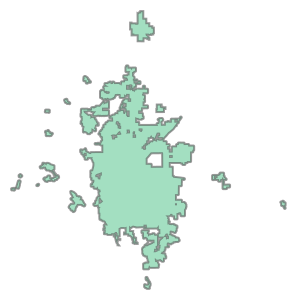

In [211]:
sidewalk_extent_gdf.geometry[0]

### check/fix geometry projection

In [212]:
total_bounds = sidewalk_gdf.geometry.total_bounds
total_bounds

array([2935159.7025    , 1508775.0615    , 3411162.9985    ,
       1980230.98999999])

In [213]:
sidewalk_extent_gdf.geometry.total_bounds

array([2932503.25159384, 1503238.87488092, 3414549.89051701,
       1991021.48166284])

In [ ]:
correct bounds: 39-41; 104-106

In [214]:
sidewalk_extent_gdf.geometry.crs

{'init': 'epsg:6428'}

In [217]:
sidewalk_gdf = sidewalk_gdf.to_crs(epsg=4326)
sidewalk_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

In [218]:
sidewalk_extent_gdf = sidewalk_extent_gdf.to_crs(epsg=4326)
sidewalk_extent_gdf.geometry.crs

{'init': 'epsg:4326', 'no_defs': True}

In [225]:
#generate random locations within boundaries
def generate_random_loc(number, polygon=sidewalk_extent_gdf.geometry, lines=sidewalk_gdf.geometry):
    loc_list = []
    (min_x, min_y, max_x, max_y) = polygon.total_bounds
    counter = 0
    while counter < number:
        pnt = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(pnt).any(0):
            loc_list.append(pnt)
            counter += 1
    return loc_list

In [226]:
sidewalk_extent_gdf.geometry.total_bounds

array([-105.73986561,   39.21354434, -104.02842171,   40.55260279])

In [228]:
locations1 = generate_random_loc(5)
locations1

## Use google_streetview module to download images

In [36]:
#Dev key is unique to each user. To run this notebook, create your own dev key and store in directory in a text file of this name.
!google_streetview -s key="google_dev_key.key"


 Set "key" default to "google_dev_key.key"


In [49]:
import urllib, os, json
down_loc = os.getcwd()
down_loc

'C:\\Users\\User\\Documents\\GitHub\\sidewalks_deep-learning'

In [171]:
# Import google_streetview for the api module
import google_streetview 
# Import google_streetview for the api and helper module

# Create a dictionary with multiple parameters separated by ;
apiargs = {
  'location': '46.414382,10.013988;40.720032,-73.988354',
  'size': '640x300;640x640',
  'heading': '90;180',
  'fov': '90;120',
  'pitch': '0;45'
}

# Get a list of all possible queries from multiple parameters
api_list = google_streetview.helpers.api_list(apiargs)

# Create a results object for all possible queries
results = google_streetview.api.results(api_list)

# Preview results
results.preview()

# Download images to directory 'downloads'
results.download_links('downloads')

# Save metadata
results.save_metadata('metadata.json')

KeyError: 'pano_id'

In [216]:
results.links[0:5]

['https://maps.googleapis.com/maps/api/streetview?location=46.414382%2C10.013988&size=640x300&heading=90&fov=90&pitch=0',
 'https://maps.googleapis.com/maps/api/streetview?location=46.414382%2C10.013988&size=640x300&heading=90&fov=90&pitch=45',
 'https://maps.googleapis.com/maps/api/streetview?location=46.414382%2C10.013988&size=640x300&heading=90&fov=120&pitch=0',
 'https://maps.googleapis.com/maps/api/streetview?location=46.414382%2C10.013988&size=640x300&heading=90&fov=120&pitch=45',
 'https://maps.googleapis.com/maps/api/streetview?location=46.414382%2C10.013988&size=640x300&heading=180&fov=90&pitch=0']

## Create custom downloading function

In [ ]:
def MetaParse(metadata_url):
    response = urllib.urlopen(metdata_url)
    json_raw = response.read()
    json_data = json.loads(json_raw)
    #return data from json response
    if json_data['status'] == "OK":
        if 'date' in json_data:
            return (json_data['date'],json_data['pano_id']) #sometimes it does not have a date!
        else:
            return (None,json_data['pano_id'])
    else:
        return (None,None)

PrevImage = [] #Global list that has previous images sampled, memoization kindof        
        
def GetStreetvw(Lon, Lat, Head, SaveLoc):
    base = r"https://maps.googleapis.com/maps/api/streetview"
    size = r"?size=800x800&fov=90&location="
    loc = str(Lat) + "," + str(Lon) + "&heading=" + str(Head)
    file_url = base + size + loc + key
    fi = "lat" + str(Lat) + "lon" + str(Lon) + "head" + str(Head) + ".jpg"
    metadata_url = base + r"/metadata" + size + loc + key
    #print MyUrl, MetaUrl #can check out image in browser to adjust size, fov to needs
    met_lis = list(MetaParse(metadata_url))                           #does not grab image if no date
    if (met_lis[1],Head) not in PrevImage and met_lis[0] is not None:   #PrevImage is global list
        urllib.urlretrieve(file_url, os.path.join(SaveLoc,fi))
        met_lis.append(fi)
        PrevImage.append((met_lis[1],Head)) #append new Pano ID to list of images
    else:
        met_lis.append(None)
    return met_lis  


### Plotting Data

In [149]:
CO_cnty_lines_url = r'https://opendata.arcgis.com/datasets/66c2642209684b90af84afcc559a5a02_5.kml?outSR=%7B%22latestWkid%22%3A4269%2C%22wkid%22%3A4269%7D'
# data sourced from https://data-cdphe.opendata.arcgis.com/datasets/66c2642209684b90af84afcc559a5a02_5
!curl -o CO_county_lines.kml $CO_cnty_lines_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  527k    0  527k    0     0   419k      0 --:--:--  0:00:01 --:--:--  419k
100 2127k    0 2127k    0     0   945k      0 --:--:--  0:00:02 --:--:--  944k
100 3678k    0 3678k    0     0  1131k      0 --:--:--  0:00:03 --:--:-- 1131k
100 5550k    0 5550k    0     0  1302k      0 --:--:--  0:00:04 --:--:-- 1302k
100 5572k    0 5572k    0     0  1307k      0 --:--:--  0:00:04 --:--:-- 1410k


In [152]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
CO_county_lines_gdf = gpd.read_file('CO_county_lines.kml', driver='KML')

In [153]:
CO_county_lines_gdf.head()

,Name,Description,geometry
0,,,"POLYGON ((-105.05673 40.34929, -105.05664 40.3..."
1,,,"POLYGON ((-104.14319 37.75834, -104.14408 37.7..."
2,,,"POLYGON ((-105.36890 38.25941, -105.36889 38.2..."
3,,,"POLYGON ((-106.79970 38.97966, -106.80041 38.9..."
4,,,"POLYGON ((-106.14888 37.40111, -106.15066 37.4..."


In [180]:
CO_county_lines_gdf.geometry.crs

{'init': 'epsg:4326'}

In [182]:
CO_county_lines_gdf.geometry.crs = {'init': 'epsg:4326'}

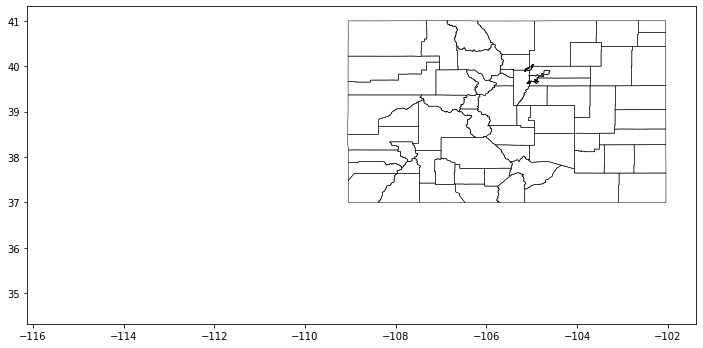

In [197]:
fig, ax = plt.subplots(figsize = (12,12))
CO_county_lines_gdf.geometry.plot(facecolor='none', linewidth=.5, edgecolor='k', ax=ax)
sidewalk_extent_gdf.geometry.plot(facecolor='blue', linewidth=.5, edgecolor='k', ax=ax)

In [163]:
ax.plot(data=CO_county_lines_gdf.geometry, facecolor='none', linewidth=.5, edgecolor='k')

[]

#### denver roads shapefile
roads_url = https://koordinates.com/layer/101991-denver-colorado-street-centerline/  
requires koordinates login to download

In [51]:
!unzip 'kx-denver-colorado-street-centerline-SHP.zip'

Archive:  kx-denver-colorado-street-centerline-SHP.zip
  inflating: denver-colorado-street-centerline.shx  
  inflating: denver-colorado-street-centerline.shp  
  inflating: denver-colorado-street-centerline.prj  
  inflating: denver-colorado-street-centerline.cpg  
  inflating: denver-colorado-street-centerline.dbf  
  inflating: denver-colorado-street-centerline.txt  


In [55]:
denver_streets_gdf = gpd.read_file('denver-colorado-street-centerline.shp')

In [56]:
denver_streets_gdf.head()

,FNODE,TNODE,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,PREFIX,...,T_ZLEV,ADMINCLASS,LRSROUTE,LRSCOMMENT,LRSBGN,LRSEND,HUNDBLKNAM,LRSMAJ,SHAPE_Leng,geometry
0,7833,7659,225.0,18944,20170608,561.0,599.0,560.0,598.0,N,...,0,2,ROSLYN ST7,LL,189.096668,371.004124,None,None,0.000477,"LINESTRING (-104.90097 39.72508, -104.90096 39..."
1,17472,17471,1607.0,27495,20170612,2851.0,2949.0,2850.0,2948.0,N,...,0,2,IOLA ST,LL,1003.936285,1492.316125,2850 BLK OF N IOLA ST,None,0.001341,"LINESTRING (-104.86455 39.75750, -104.86453 39..."
2,6163,6077,585.0,16501,20171024,400.0,498.0,401.0,499.0,None,...,0,2,13TH ST2,LR,142.786524,487.322780,400 BLK OF 13TH ST,None,0.001102,"LINESTRING (-104.99318 39.74039, -104.99360 39..."
3,6615,6465,402.0,4383,20020930,1301.0,1399.0,1300.0,1398.0,N,...,0,2,TENNYSON ST2,LR,458.896668,1124.667485,1300 BLK OF N TENNYSON ST,TENNYSON ST2 37,0.001828,"LINESTRING (-105.04400 39.73665, -105.04400 39..."
4,10731,10652,874.0,6514,20171024,2000.0,2098.0,2001.0,2099.0,W,...,0,2,WTENNESSEAV5,UR,1701.626782,1962.379486,2000 BLK OF W TENNESSEE AVE,None,0.000868,"LINESTRING (-105.01262 39.69832, -105.01299 39..."


In [188]:
denver_streets_gdf.geometry.crs

{'init': 'epsg:4326'}

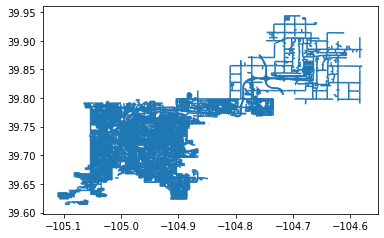

In [174]:
denver_streets_gdf.geometry.plot()

In [ ]:
#data source: https://data.drcog.org/dataset/edge-of-pavement-lines-2016
